## Accessing GOES Geostationary Lightning Mapper (GLM) with the Planetary Computer STAC API

The [Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html) is a single-channel, near-infrared optical transient detector that can detect the momentary changes in an optical scene, indicating the presence of lightning. GLM measures total lightning (in-cloud, cloud-to-cloud and cloud-to-ground) activity continuously over the Americas and adjacent ocean regions with near-uniform spatial resolution of approximately 10 km. GLM collects information such as the frequency, location and extent of lightning discharges to identify intensifying thunderstorms and tropical cyclones. Trends in total lightning available from the GLM provide critical information to forecasters, allowing them to focus on developing severe storms much earlier and before these storms produce damaging winds, hail or even tornadoes.

The GLM data product consists of a hierarchy of earth-located lightning radiant energy measures including events, groups, and flashes:

- Lightning "events" are detected by the instrument.
- Lightning "groups" are a collection of one or more lightning events that satisfy temporal and spatial coincidence thresholds.
- Similarly, lightning "flashes" are a collection of one or more lightning groups that satisfy temporal and spatial coincidence thresholds.
The product includes the relationship among lightning events, groups, and flashes, and the area coverage of lightning groups and flashes. The product also includes processing and data quality metadata, and satellite state and location information.

This Collection contains GLM L2 data in tabular ([GeoParquet](https://github.com/opengeospatial/geoparquet)) format and the original source NetCDF format. The NetCDF files are delivered to Azure as part of the [NOAA Open Data Dissemination (NODD) Program](https://www.noaa.gov/information-technology/open-data-dissemination).

### Data Access
This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable "PC_SDK_SUBSCRIPTION_KEY" when your server is started. The API key may be manually set via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more. 

In [1]:
import planetary_computer
import pystac_client
import rich.table

import pandas as pd
from geopandas import GeoSeries

# Open the Planetary Computer STAC API
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)

The GOES GLM product is queried by datetime and the "GOES-16" and "GOES-17" platforms. 

In [2]:
# Fetch the collection of interest and display available items
search = catalog.search(
    collections="goes-glm",
    datetime="2022-07-09T00:02:50Z",
    query={"platform": {"eq": "GOES-17"}},
)
items = list(search.get_items())
items

[<Item id=OR_GLM-L2-LCFA_G17_s20221900002400_e20221900003000>]

### Available Assets

Let's display the available assets and metadata for the GOES GLM product. 

In [3]:
# Assets
t = rich.table.Table("Key", "Value")
for key, asset in items[0].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key     ┃ Value                                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ events  │ Processed GeoParquet file for events  │
│ groups  │ Processed GeoParquet file for groups  │
│ netcdf  │ Original NetCDF4 file                 │
│ flashes │ Processed GeoParquet file for flashes │
└─────────┴───────────────────────────────────────┘

In [4]:
# Metadata
t = rich.table.Table("Key", "Value")
for k, v in sorted(items[0].properties.items()):
    t.add_row(k, str(v))
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                                  ┃ Value                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                        │ GOES                        │
│ datetime                             │ 2022-07-09T00:02:50Z        │
│ end_datetime                         │ 2022-07-09T00:03:00.0Z      │
│ goes:event_count                     │ 3483                        │
│ goes:flash_count                     │ 270                         │
│ goes:flash_time_threshold            │ 3.3299999237060547          │
│ goes:group_count                     │ 1990                        │
│ goes:group_time_threshold            │ 0.0                         │
│ goes:lightning_wavelength            │ 777.3699951171875           │
│ goes:nominal_satellite_height        │ 35786.0234375               │
│ goes:nominal_satellite_subpoint_lat  │ 0.0                         │
│ goes:nominal_satellite_subpoint_lon  │ -137.1999969482422          │
│ goes:orbital_slot                    │ West                        │
│ goes:percent_navigated_L1b_events    │ 1.0                         │
│ goes:percent_uncorrectable_L0_errors │ 0.0                         │
│ goes:system_environment              │ OR                          │
│ goes:yaw_flip_flag                   │ 0                           │
│ gsd                                  │ 8000                        │
│ instruments                          │ ['FM2']                     │
│ mission                              │ GOES                        │
│ platform                             │ GOES-17                     │
│ processing:facility                  │ WCDAS                       │
│ processing:level                     │ L2                          │
│ proj:centroid                        │ {'lat': 0.0, 'lon': -137.0} │
│ proj:epsg                            │ 4326                        │
│ start_datetime                       │ 2022-07-09T00:02:40.0Z      │
└──────────────────────────────────────┴─────────────────────────────┘

### Loading the GeoParquet dataset
Now let's load a STAC item into a tabular format. 

In [5]:
# Display the GOES GLM tabular data
asset = items[0].assets["groups"]

df = pd.read_parquet(asset.href)
df

,geometry,id,time,time_offset,frame_time,frame_time_offset,area,energy,quality_flag,parent_flash_id
0,b'\x01\x01\x00\x00\x00\x00\x00\x00@\xa7sX\xc0\...,125569481,2022-07-09 00:02:39.031434+00:00,-0.968566,2022-07-09 00:02:39.158465+00:00,-0.841535,156111696.0,1.628323e-14,0,28775
1,b'\x01\x01\x00\x00\x00\x00\x00\x00\xa0\xa0sX\x...,125569482,2022-07-09 00:02:39.033341+00:00,-0.966659,2022-07-09 00:02:39.160373+00:00,-0.839627,156111696.0,3.108145e-14,0,28775
2,b'\x01\x01\x00\x00\x00\x00\x00\x00@\xcesX\xc0\...,125569483,2022-07-09 00:02:39.035249+00:00,-0.964751,2022-07-09 00:02:39.162281+00:00,-0.837719,156111696.0,3.438106e-14,0,28775
3,b'\x01\x01\x00\x00\x00\x00\x00\x00@\xd5sX\xc0\...,125569484,2022-07-09 00:02:39.100863+00:00,-0.899137,2022-07-09 00:02:39.227894+00:00,-0.772106,156111696.0,1.308361e-14,0,28775
4,b'\x01\x01\x00\x00\x00\x00\x00\x00\xa0FrX\xc0\...,125569492,2022-07-09 00:02:39.194324+00:00,-0.805676,2022-07-09 00:02:39.321356+00:00,-0.678644,78132152.0,8.084214e-15,0,28775
...,...,...,...,...,...,...,...,...,...,...
1985,b'\x01\x01\x00\x00\x00\x00\x00\x00 y\x91U\xc0\...,125571648,2022-07-09 00:02:59.352640+00:00,19.352640,2022-07-09 00:02:59.484249+00:00,19.484249,82099800.0,7.384298e-15,0,29180
1986,b'\x01\x01\x00\x00\x00\x00\x00\x00 6\x97U\xc0\...,125571649,2022-07-09 00:02:59.416346+00:00,19.416346,2022-07-09 00:02:59.547955+00:00,19.547955,81947200.0,1.038394e-14,0,29180
1987,b'\x01\x01\x00\x00\x00\x00\x00\x00\xe09\x94U\x...,125571650,2022-07-09 00:02:59.418253+00:00,19.418253,2022-07-09 00:02:59.549862+00:00,19.549862,327941408.0,9.507378e-14,0,29180
1988,b'\x01\x01\x00\x00\x00\x00\x00\x00@+\x95U\xc0\...,125571653,2022-07-09 00:02:59.468227+00:00,19.468227,2022-07-09 00:02:59.599455+00:00,19.599455,163894400.0,3.088148e-14,0,29180


### Displaying the data

Let's display the GOES GLM product across the western hemisphere. 

In [6]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [7]:
# Convert the WKB geometries into coordinates
gdf = GeoSeries.from_wkb(df.geometry, index=None, crs=None)
gdf

0       POINT (-97.80708 20.08443)
1       POINT (-97.80668 20.08446)
2       POINT (-97.80946 20.08434)
3       POINT (-97.80989 20.08422)
4       POINT (-97.78556 20.08537)
                   ...            
1985    POINT (-86.27302 31.93991)
1986    POINT (-86.36268 31.84871)
1987    POINT (-86.31603 31.87083)
1988    POINT (-86.33076 31.88128)
1989    POINT (-86.32122 31.89093)
Length: 1990, dtype: geometry

Text(0.5, 1.0, 'GOES Geostationary Lightning Mapper (GLM) \n 2022-07-09T00:02:50Z')

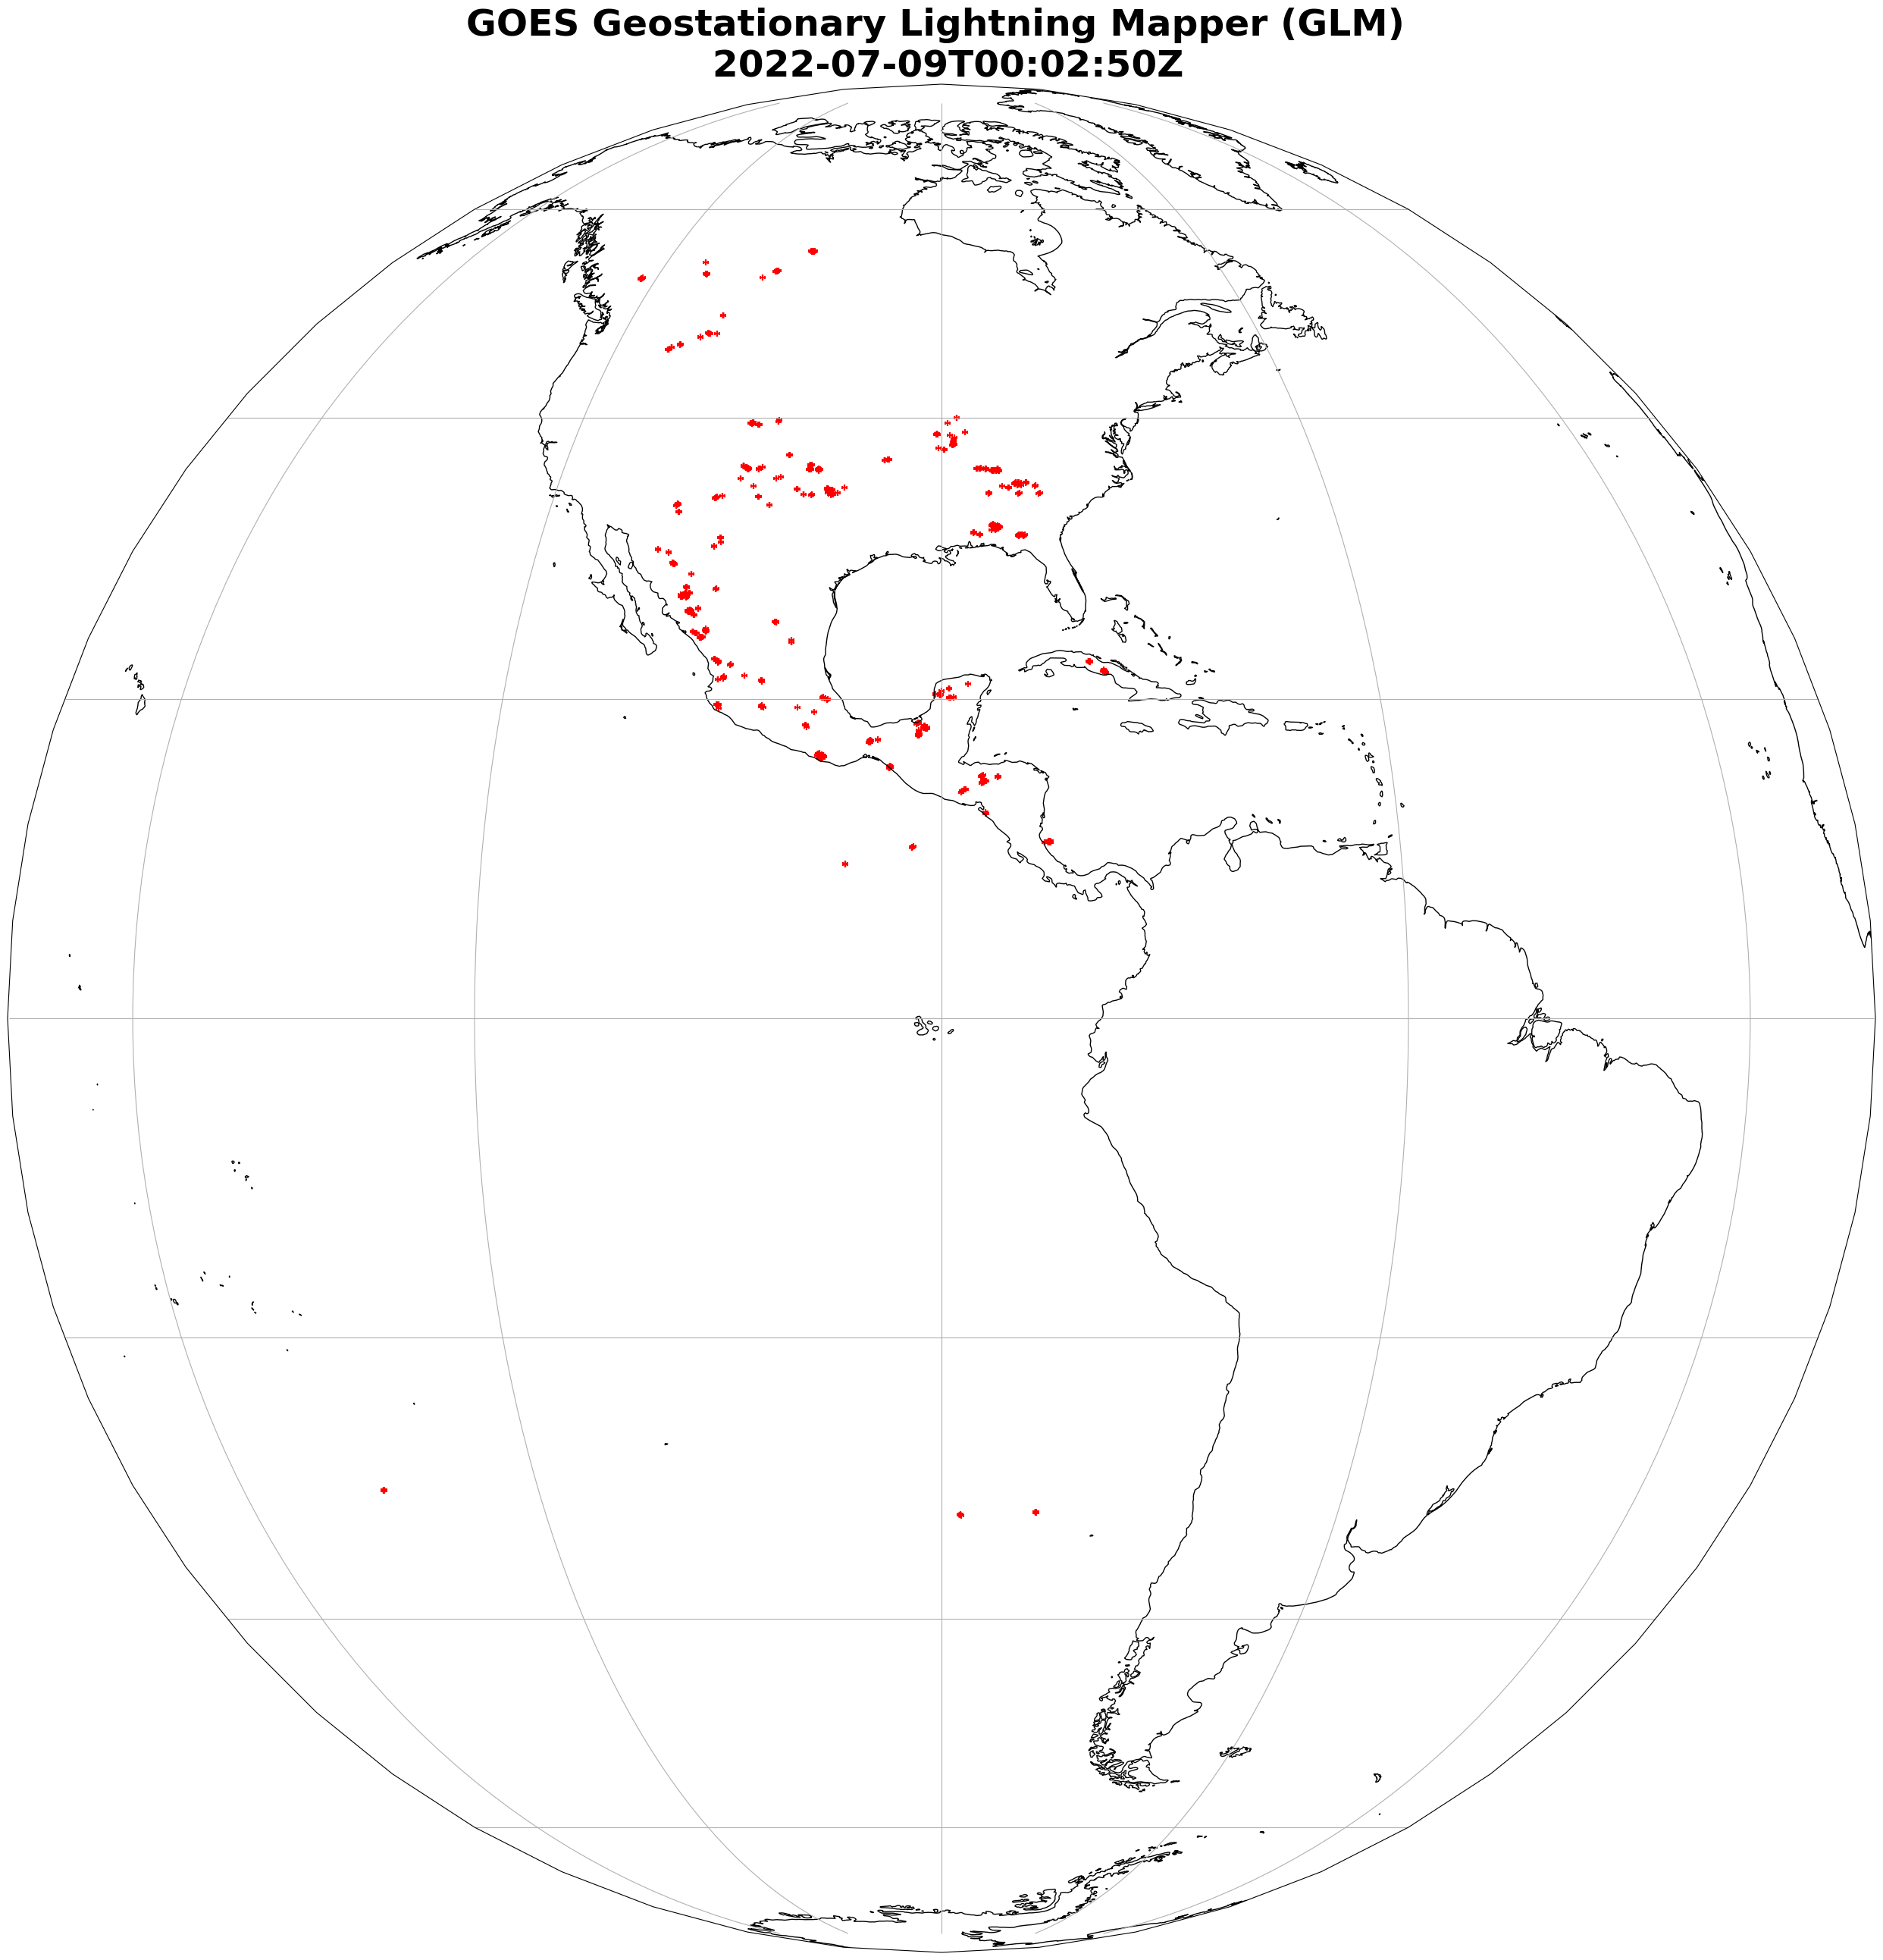

In [8]:
# Display the GOES GLM "group" product centriod location
fig, ax = plt.subplots(
    figsize=(32, 32),
    subplot_kw=dict(projection=ccrs.Orthographic(central_longitude=-90.0)),
)

GeoSeries.plot(gdf, ax=ax, facecolor="red", marker="+", transform=ccrs.PlateCarree())

ax.coastlines(resolution="50m")
ax.set_global()
ax.gridlines()
ax.set_title(
    "GOES Geostationary Lightning Mapper (GLM) \n 2022-07-09T00:02:50Z",
    fontweight="bold",
    fontsize="35",
)